In [160]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [161]:
drop_cols = [
    "StartDate", "EndDate", "Status", "Progress", "Duration (in seconds)",
    "Finished", "RecordedDate", "DistributionChannel",
    "UserLanguage", "Q_RecaptchaScore", "Q352", "Q353"]

politicians = {
    1: "Trump",              # Donald Trump
    2: "Biden",              # Joe Biden
    3: "Lee",                # Lee Jae-myung
    4: "Yoon",               # Yoon Suk Yeol
    5: "Paetongtarn",        # Paetongtarn Shinawatra
    6: "Prayut",             # Prayut Chan-o-cha
    8: "Jacinda",            # Jacinda Ardern
    9: "Luxon",              # Christopher Luxon
    10: "Albanese",          # Anthony Albanese
    11: "Morrison",          # Scott Morrison
    12: "Starmer",           # Keir Starmer
    13: "Sunak",             # Rishi Sunak
    14: "Friedrich",         # Friedrich Merz
    15: "Olaf",              # Olaf Scholz
    16: "Bolsonaro",         # Jair Bolsonaro
    17: "Lula",              # Luiz Inácio Lula da Silva
    18: "Singh",             # Manmohan Singh
    19: "Modi",              # Narendra Modi
    20: "Harper",            # Stephen Harper
    21: "Trudeau",           # Justin Trudeau
    22: "Kenyatta",          # Uhuru Kenyatta
    23: "Ruto",              # William Ruto
    24: "Masisi",            # Mokgweetsi Masisi
    25: "Boko",              # Duma Boko
}

phase2_familiarity = {
    "Q328": "Joe Biden",
    "Q329": "Donald Trump",
    "Q330": "Yoon Suk Yeol",
    "Q331": "Lee Jae-myung",
    "Q332": "Prayut Chan-o-cha",
    "Q333": "Paetongtarn Shinawatra",
    "Q334": "Christopher Luxon",
    "Q335": "Jacinda Ardern",
    "Q336": "Scott Morrison",
    "Q337": "Anthony Albanese",
    "Q338": "Rishi Sunak",
    "Q339": "Keir Starmer",
    "Q340": "Olaf Scholz",
    "Q341": "Friedrich Merz",
    "Q342": "Luiz Inácio Lula da Silva",
    "Q343": "Jair Bolsonaro",
    "Q344": "Narendra Modi",
    "Q345": "Manmohan Singh",
    "Q346": "Justin Trudeau",
    "Q347": "Stephen Harper",
    "Q348": "William Ruto",
    "Q349": "Uhuru Kenyatta",
    "Q350": "Duma Boko",
    "Q351": "Mokgweetsi Masisi"
}



demographic_column = {
    'ResponseId': 'response_id',
    'Q2': 'age',
    'Q3': 'sex', 
    'Q4': 'country',
    'Q5': 'political_engagement',
    'Q6_1': 'political_alignment'
}

demographic_cols = list(demographic_column.values())

countries_by_continent = {
    "Europe": [
        "Albania", "Andorra", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina",
        "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland",
        "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Monaco", "Montenegro",
        "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Republic of Moldova",
        "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain",
        "Sweden", "Switzerland", "Ukraine", "United Kingdom of Great Britain and Northern Ireland"
    ],
    "Asia": [
        "Afghanistan", "Armenia", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan", "Brunei Darussalam",
        "Cambodia", "China", "Georgia", "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan",
        "Kazakhstan", "Kuwait", "Kyrgyzstan", "Lao People's Democratic Republic", "Lebanon", "Malaysia",
        "Maldives", "Mongolia", "Myanmar", "Nepal", "North Korea", "Oman", "Pakistan", "Palestine",
        "Philippines", "Qatar", "Saudi Arabia", "Singapore", "South Korea", "Sri Lanka", "Syria",
        "Tajikistan", "Thailand", "Timor-Leste", "Turkey", "Turkmenistan", "United Arab Emirates",
        "Uzbekistan", "Vietnam", "Yemen"
    ],
    "Americas": [
        "Antigua and Barbuda", "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil",
        "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador",
        "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico",
        "Nicaragua", "Panama", "Paraguay", "Peru", "Saint Kitts and Nevis", "Saint Lucia",
        "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "United States of America",
        "Uruguay", "Venezuela"
    ],
    "Oceania": [
        "Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand",
        "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"
    ],
    "Africa": [
        "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon",
        "Central African Republic", "Chad", "Comoros", "Congo, Republic of the...", "Democratic Republic of the Congo",
        "Côte d'Ivoire", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon",
        "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Libya",
        "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger",
        "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia",
        "South Africa", "South Sudan", "Sudan", "Togo", "Tunisia", "Uganda", "United Republic of Tanzania",
        "Zambia", "Zimbabwe"
    ]
}

agree_scale_mapper = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly Agree': 5,
}

In [162]:
main_df = pd.read_csv('data/raw_data.csv')
main_df = main_df.drop([0, 1]).reset_index(drop=True) if len(main_df) > 2 else main_df
main_df = main_df.drop(columns=drop_cols)
main_df = main_df.rename(columns=demographic_column)
main_df.head()

,response_id,age,sex,Q3_4_TEXT,country,political_engagement,political_alignment,2_Q7,2_Q8,2_Q14_1,...,Rankings_Masisi_Q3,Rankings_Masisi_Q4,Rankings_Masisi_Q5,Rankings_Masisi_Q6,Rankings_Masisi_Q7,Rankings_Masisi_Q8,Rankings_Masisi_Q9,Rankings_Masisi_Q10,Rankings_Masisi_Q11,Rankings_Masisi_Q12
0,R_8uvn93t4ClMtXb0,18-24 years old,Male,NaN,Thailand,Often,2,Very familiar,Somewhat negative,2,...,"3,1,2,4","3,2,1,4","3,2,1,4","1,4,3,2","4,1,2,3","3,2,1,4","3,2,1,4","3,1,2,4","3,1,2,4","4,2,1,3"
1,R_2QQgDHQ3fSXt9QU,25-34 years old,Female,NaN,Thailand,Always,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R_8n9s1J69kFsj8L0,18-24 years old,Male,NaN,United Kingdom of Great Britain and Northern I...,Always,4,NaN,NaN,NaN,...,"2,1,3,4","3,2,1,4","1,2,3,4","2,4,3,1","3,1,2,4","2,1,3,4","2,1,3,4","2,1,3,4","3,2,1,4","1,2,3,4"
3,R_2aFiUJGcieOSRSj,25-34 years old,Male,NaN,Thailand,Often,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R_2HidVxTG4ScY993,25-34 years old,Male,NaN,Finland,Often,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Phase 1 Data Extractor

In [163]:
def get_column_rename_mapping(politician_number):
    """
    Get the politician-specific column rename mapping
    
    Args:
        politician_number: integer representing the politician (1-25)
    
    Returns:
        Dictionary mapping original politician-specific column names to new names
    """
    
    # Politician-specific columns rename mapping
    politician_rename = {
        # Left
        f'{politician_number}_Q7': 'familiarity',
        f'{politician_number}_Q8': 'pre_opinion',
        f'{politician_number}_Q14_1': 'competence',
        f'{politician_number}_Q14_2': 'likable',
        f'{politician_number}_Q14_3': 'trustworthy',
        f'{politician_number}_Q14_4': 'approachable',
        f'{politician_number}_Q14_5': 'charismatic',
        f'{politician_number}_Q14_6': 'aggressive',
        f'{politician_number}_Q14_7': 'friendly',
        f'{politician_number}_Q14_8': 'professional',
        f'{politician_number}_Q17_1': 'visually_appealing',
        f'{politician_number}_Q17_2': 'professionally_designed',
        f'{politician_number}_Q17_3': 'aggressive_poster',
        f'{politician_number}_Q17_4': 'inspirational',
        f'{politician_number}_Q17_5': 'manipulative',
        f'{politician_number}_Q17_6': 'boring',
        f'{politician_number}_Q17_7': 'misleading',
        f'{politician_number}_Q12': 'match_pol_comm',
        f'{politician_number}_Q13': 'credible_typo_color',
        f'{politician_number}_Q19': 'background',
        f'{politician_number}_Q20': 'typo_attention',
        f'{politician_number}_Q21': 'support',
        f'{politician_number}_Q20.1': 'understand_lang',  
        f'{politician_number}_Q21.1': 'poster_meaning',
        f'{politician_number}_Q22': 'interested_in',
        f'{politician_number}_Q23': 'msg_understand',
        f'{politician_number}_Q23_8_TEXT': 'other_msg_understand',
        f'{politician_number}_Q23.1': 'post_opinion',
        # Right
        f'{politician_number}_Q49': 'familiarity',
        f'{politician_number}_Q50': 'pre_opinion',
        f'{politician_number}_Q51_1': 'competence',
        f'{politician_number}_Q51_2': 'likable',
        f'{politician_number}_Q51_3': 'trustworthy',
        f'{politician_number}_Q51_4': 'approachable',
        f'{politician_number}_Q51_5': 'charismatic',
        f'{politician_number}_Q51_6': 'aggressive',
        f'{politician_number}_Q51_7': 'friendly',
        f'{politician_number}_Q51_8': 'professional',
        f'{politician_number}_Q52_1': 'visually_appealing',
        f'{politician_number}_Q52_2': 'professionally_designed',
        f'{politician_number}_Q52_3': 'aggressive_poster',
        f'{politician_number}_Q52_4': 'inspirational',
        f'{politician_number}_Q52_5': 'manipulative',
        f'{politician_number}_Q52_6': 'boring',
        f'{politician_number}_Q52_7': 'misleading',
        f'{politician_number}_Q53': 'match_pol_comm',
        f'{politician_number}_Q54': 'credible_typo_color',
        f'{politician_number}_Q55': 'background',
        f'{politician_number}_Q56': 'typo_attention',
        f'{politician_number}_Q57': 'support',
        f'{politician_number}_Q58': 'interested_in',
        f'{politician_number}_Q59': 'understand_lang',
        f'{politician_number}_Q60': 'poster_meaning',
        f'{politician_number}_Q61': 'msg_understand',
        f'{politician_number}_Q61_8_TEXT': 'other_msg_understand',
        f'{politician_number}_Q62': 'post_opinion'
    }

    
    return politician_rename    


def filter_politician_columns(df, politician_number, demographic_columns=None):
    """
    Filter columns for a specific politician based on the number prefix,
    including demographic columns, renaming columns, and filtering out rows with all empty responses
    
    Args:
        df: pandas DataFrame with the survey data
        politician_number: integer representing the politician (1-25)
        demographic_columns: list of demographic column names (already renamed)
    
    Returns:
        DataFrame with demographic columns + politician-specific columns,
        with renamed columns and filtered to only include rows with at least one non-empty politician response
    """
    
    # Define demographic columns - use provided list or default
    if demographic_columns is None:
        demographic_columns = ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment']
    
    # Create pattern to match columns starting with the politician number
    pattern = f"^{politician_number}_"
    
    # Find all columns that match the pattern
    politician_specific_columns = [col for col in df.columns if re.match(pattern, col)]
    
    # Combine demographic columns with politician-specific columns
    # Only include demographic columns that actually exist in the DataFrame
    available_demographic_columns = [col for col in demographic_columns if col in df.columns]
    all_columns = available_demographic_columns + politician_specific_columns
    
    if not politician_specific_columns:
        print(f"Warning: No columns found for politician number {politician_number}")
        return pd.DataFrame()
    
    # Create DataFrame with selected columns
    filtered_df = df[all_columns].copy()
    
    # Filter out rows where ALL politician-specific responses are empty/null
    # A row is kept if at least one politician-specific column has a non-null, non-empty value
    politician_responses = filtered_df[politician_specific_columns]
    
    # Check for non-null and non-empty values (handles both NaN and empty strings)
    has_response = politician_responses.notna() & (politician_responses != '') & (politician_responses != ' ')
    rows_with_responses = has_response.any(axis=1)
    
    # Filter the DataFrame to only include rows with at least one response
    filtered_df = filtered_df[rows_with_responses].copy()
    
    # Rename politician-specific columns using the mapping
    politician_rename_mapping = get_column_rename_mapping(politician_number)
    
    # Only rename columns that exist in the DataFrame
    existing_rename_mapping = {old_name: new_name for old_name, new_name in politician_rename_mapping.items() 
                              if old_name in filtered_df.columns}
    
    filtered_df = filtered_df.rename(columns=existing_rename_mapping)
    
    categorial_columns = ['match_pol_comm', 'credible_typo_color', 'background', 'typo_attention', 'support', 'interested_in']
    
    for col in categorial_columns:
        if col in filtered_df.columns:
            filtered_df[col] = (
                                filtered_df[col]
                                .map(agree_scale_mapper)
                                .fillna(-99) 
                                .astype(int)
                            )
                        
    return filtered_df

def create_all_politician_dataframes(df):
    """
    Create individual DataFrames for each politician with common columns included,
    renamed columns, and filtered to only include rows with responses
    
    Args:
        df: pandas DataFrame with the survey data
    
    Returns:
        Dictionary with politician names as keys and their DataFrames as values
    """
    politician_dataframes = {}
    
    for politician_num, politician_name in politicians.items():
        # Filter columns for this politician
        politician_df = filter_politician_columns(df, politician_num, demographic_cols)
        
        # Only add to dictionary if DataFrame has data
        if not politician_df.empty and len(politician_df) > 0:
            politician_dataframes[politician_name] = politician_df
            print(f"Created DataFrame for {politician_name}:")
            print(f"  - {len(politician_df.columns)} columns total")
            print(f"  - {len(politician_df)} rows with responses")
            print(f"  - Columns: {list(politician_df.columns)}")
            print()
    
    return politician_dataframes


# If you want to save each politician's data to separate CSV files:
def save_politician_dataframes(politician_dfs, phase, output_directory="phase1_data"):
    """Save each politician's DataFrame to a separate CSV file"""
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    for politician_name, politician_df in politician_dfs.items():
        # Clean filename (remove special characters)
        clean_name = re.sub(r'[^\w\s-]', '', politician_name.lower()).strip().replace(' ', '_')
        filename = f"{output_directory}/{clean_name}_phase{phase}_data.csv"
        politician_df.to_csv(filename, index=False)
        print(f"Saved {politician_name} data to {filename}")

In [164]:
politician_dfs = create_all_politician_dataframes(main_df)

Created DataFrame for Trump:
  - 34 columns total
  - 18 rows with responses
  - Columns: ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment', 'familiarity', 'pre_opinion', 'competence', 'likable', 'trustworthy', 'approachable', 'charismatic', 'aggressive', 'friendly', 'professional', 'visually_appealing', 'professionally_designed', 'aggressive_poster', 'inspirational', 'manipulative', 'boring', 'misleading', 'match_pol_comm', 'credible_typo_color', 'background', 'typo_attention', 'support', 'interested_in', 'understand_lang', 'poster_meaning', 'msg_understand', 'other_msg_understand', 'post_opinion']

Created DataFrame for Biden:
  - 34 columns total
  - 16 rows with responses
  - Columns: ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment', 'familiarity', 'pre_opinion', 'competence', 'likable', 'trustworthy', 'approachable', 'charismatic', 'aggressive', 'friendly', 'professional', 'visually_appealing', 'professiona

In [165]:
biden_df = politician_dfs["Biden"]
print(biden_df.shape)
biden_df.head()

(16, 34)


,response_id,age,sex,country,political_engagement,political_alignment,familiarity,pre_opinion,competence,likable,...,credible_typo_color,background,typo_attention,support,interested_in,understand_lang,poster_meaning,msg_understand,other_msg_understand,post_opinion
0,R_8uvn93t4ClMtXb0,18-24 years old,Male,Thailand,Often,2,Very familiar,Somewhat negative,2,3,...,3,4,2,2,3,Yes,Yes,"Language,Color scheme used,Symbols or Visual I...",NaN,Neutral
7,R_8giIrB0yyt2ZEaf,18-24 years old,Male,Thailand,Often,2,Moderately familiar,Somewhat positive,5,4,...,2,3,3,2,2,Yes,No,NaN,NaN,Neutral
20,R_25HI5FfPB1IHRgt,45-54 years old,Female,South Africa,Often,4,Moderately familiar,Neutral,1,4,...,4,4,4,2,2,Yes,Yes,"Language,Facial expression of the politician,F...",NaN,Somewhat positive
23,R_11vM4y4keMTyvTa,55-64 years old,Male,United States of America,Sometimes,4,Extremely familiar,Extremely negative,1,1,...,5,5,4,1,1,Yes,Yes,"Language,Facial expression of the politician,F...",NaN,Extremely negative
38,R_4iNoFuwzhg2ywGl,18-24 years old,Female,Australia,Sometimes,3,Slightly familiar,Somewhat negative,3,3,...,3,3,2,1,1,Yes,Yes,"Language,Facial expression of the politician,F...",NaN,Neutral


In [166]:
save_politician_dataframes(politician_dfs, phase="1")

Saved Trump data to phase1_data/trump_phase1_data.csv
Saved Biden data to phase1_data/biden_phase1_data.csv
Saved Lee data to phase1_data/lee_phase1_data.csv
Saved Yoon data to phase1_data/yoon_phase1_data.csv
Saved Paetongtarn data to phase1_data/paetongtarn_phase1_data.csv
Saved Prayut data to phase1_data/prayut_phase1_data.csv
Saved Jacinda data to phase1_data/jacinda_phase1_data.csv
Saved Luxon data to phase1_data/luxon_phase1_data.csv
Saved Albanese data to phase1_data/albanese_phase1_data.csv
Saved Morrison data to phase1_data/morrison_phase1_data.csv
Saved Starmer data to phase1_data/starmer_phase1_data.csv
Saved Sunak data to phase1_data/sunak_phase1_data.csv
Saved Friedrich data to phase1_data/friedrich_phase1_data.csv
Saved Olaf data to phase1_data/olaf_phase1_data.csv
Saved Bolsonaro data to phase1_data/bolsonaro_phase1_data.csv
Saved Lula data to phase1_data/lula_phase1_data.csv
Saved Singh data to phase1_data/singh_phase1_data.csv
Saved Modi data to phase1_data/modi_phase1

### Demographic Visualization

In [167]:
def plot_demographic_overview(main_df, politician_dfs=None, figsize=(20, 15)):
    """
    Create a comprehensive overview of demographic information across all politicians
    
    Args:
        main_df: Main DataFrame with all demographic data (already renamed columns)
        politician_dfs: Optional - Dictionary with politician DataFrames (for sample size calculation)
        figsize: Figure size tuple
    """
    # Use main_df directly - much more efficient!
    combined_df = main_df[['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment']].copy()
    
    # Create subplots
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    fig.suptitle('Demographic Overview Across All Politicians', fontsize=20, fontweight='bold')
    
    # 1. Age Group Distribution (categorical, not numeric)
    age_counts = combined_df['age'].value_counts().sort_index()
    axes[0, 0].bar(range(len(age_counts)), age_counts.values, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xticks(range(len(age_counts)))
    axes[0, 0].set_xticklabels(age_counts.index, rotation=45, ha='right', fontsize=9)
    axes[0, 0].set_title('Age Group Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Age Group')
    axes[0, 0].set_ylabel('Frequency')

    
    # 2. Sex Distribution
    sex_counts = combined_df['sex'].value_counts()
    axes[0, 1].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Sex Distribution', fontweight='bold')
    
    # 3. Country Distribution (Top 10)
    continent_counts = {continet: 0 for continet in countries_by_continent.keys()}
    for country in combined_df['country']:
        for continent, countries in countries_by_continent.items():
            if country in countries:
                continent_counts[continent] += 1
                break   
    
    continent_counts_series = pd.Series(continent_counts)
    # country_counts = combined_df['country'].value_counts().head(10)
    # axes[0, 2].barh(range(len(country_counts)), country_counts.values)
    # axes[0, 2].set_yticks(range(len(country_counts)))
    # axes[0, 2].set_yticklabels(country_counts.index, fontsize=9)
    # axes[0, 2].set_title('Top 10 Countries', fontweight='bold')
    # axes[0, 2].set_xlabel('Count')

    axes[0, 2].barh(range(len(continent_counts_series)), continent_counts_series.values)
    axes[0, 2].set_yticks(range(len(continent_counts_series)))
    axes[0, 2].set_yticklabels(continent_counts_series.index, fontsize=9)
    axes[0, 2].set_title('Continent', fontweight='bold')
    axes[0, 2].set_xlabel('Count')
    
    # 4. Political Engagement Distribution
    engagement_counts = combined_df['political_engagement'].value_counts()
    axes[1, 0].bar(range(len(engagement_counts)), engagement_counts.values, alpha=0.7)
    axes[1, 0].set_xticks(range(len(engagement_counts)))
    axes[1, 0].set_xticklabels(engagement_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 0].set_title('Political Engagement', fontweight='bold')
    axes[1, 0].set_ylabel('Count')
    
    # 5. Political Alignment Distribution
    alignment_counts = combined_df['political_alignment'].value_counts()
    axes[1, 1].bar(range(len(alignment_counts)), alignment_counts.values, alpha=0.7)
    axes[1, 1].set_xticks(range(len(alignment_counts)))
    axes[1, 1].set_xticklabels(alignment_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_title('Political Alignment', fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    
    # 6. Sample Size by Politician (if politician_dfs provided)
    if politician_dfs:
        sample_sizes = [len(df) for df in politician_dfs.values()]
        politician_names = list(politician_dfs.keys())
        axes[1, 2].barh(range(len(sample_sizes)), sample_sizes, alpha=0.7)
        axes[1, 2].set_yticks(range(len(sample_sizes)))
        axes[1, 2].set_yticklabels([name.split()[-1] for name in politician_names], fontsize=8)  # Use last name
        axes[1, 2].set_title('Sample Size by Politician', fontweight='bold')
        axes[1, 2].set_xlabel('Number of Responses')
    else:
        # Show total sample size instead
        total_responses = len(combined_df)
        axes[1, 2].text(0.5, 0.5, f'Total Sample Size:\n{total_responses:,} responses', 
                       ha='center', va='center', fontsize=14, fontweight='bold',
                       transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('Total Sample Size', fontweight='bold')
        axes[1, 2].axis('off')
    
    # 7. Age Group vs Political Engagement
    try:
        age_engagement_crosstab = pd.crosstab(combined_df['age'], combined_df['political_engagement'])
        sns.heatmap(age_engagement_crosstab, annot=True, fmt='d', ax=axes[2, 0], cmap='Blues')
        axes[2, 0].set_title('Age Group vs Political Engagement', fontweight='bold')
        axes[2, 0].set_xlabel('Political Engagement')
        axes[2, 0].set_ylabel('Age Group')
    except:
        axes[2, 0].text(0.5, 0.5, 'Insufficient data for heatmap', ha='center', va='center')
        axes[2, 0].set_title('Age Group vs Political Engagement', fontweight='bold')
    
    # 8. Sex vs Political Alignment Heatmap
    try:
        sex_alignment_crosstab = pd.crosstab(combined_df['sex'], combined_df['political_alignment'])
        sns.heatmap(sex_alignment_crosstab, annot=True, fmt='d', ax=axes[2, 1], cmap='Blues')
        axes[2, 1].set_title('Sex vs Political Alignment', fontweight='bold')
    except:
        axes[2, 1].text(0.5, 0.5, 'Insufficient data for heatmap', ha='center', va='center')
        axes[2, 1].set_title('Sex vs Political Alignment', fontweight='bold')
    
    # 9. Response Rate Summary
    total_responses = len(combined_df)
    
    if politician_dfs:
        total_politicians = len(politician_dfs)
        avg_responses = total_responses / total_politicians if total_politicians > 0 else 0
        axes[2, 2].text(0.1, 0.8, f'Total Politicians: {total_politicians}', fontsize=12, transform=axes[2, 2].transAxes)
        axes[2, 2].text(0.1, 0.6, f'Total Responses: {total_responses:,}', fontsize=12, transform=axes[2, 2].transAxes)
        axes[2, 2].text(0.1, 0.4, f'Avg per Politician: {avg_responses:.1f}', fontsize=12, transform=axes[2, 2].transAxes)
    else:
        unique_responses = combined_df['response_id'].nunique()
        axes[2, 2].text(0.1, 0.7, f'Total Responses: {total_responses:,}', fontsize=12, transform=axes[2, 2].transAxes)
        axes[2, 2].text(0.1, 0.5, f'Unique Response IDs: {unique_responses:,}', fontsize=12, transform=axes[2, 2].transAxes)
        axes[2, 2].text(0.1, 0.3, f'Response Rate: 100%', fontsize=12, transform=axes[2, 2].transAxes)
    
    axes[2, 2].set_title('Summary Statistics', fontweight='bold')
    axes[2, 2].axis('off')
    
    print(f"Continent Distribution:\n{continent_counts}\n")
    
    plt.tight_layout()
    plt.show()

def plot_individual_politician_demographics(politician_df, politician_name, figsize=(15, 10)):
    """
    Create detailed demographic visualization for a single politician
    
    Args:
        politician_df: DataFrame for a specific politician
        politician_name: Name of the politician
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Demographic Analysis for {politician_name}', fontsize=16, fontweight='bold')
    
    # 1. Age Group Distribution (categorical)
    age_counts = politician_df['age'].value_counts().sort_index()
    if not age_counts.empty:
        bars = axes[0, 0].bar(range(len(age_counts)), age_counts.values, 
                             alpha=0.7, edgecolor='black', color='skyblue')
        axes[0, 0].set_xticks(range(len(age_counts)))
        axes[0, 0].set_xticklabels(age_counts.index, rotation=45, ha='right', fontsize=9)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(height)}', ha='center', va='bottom')
        
        # Show most common age group
        most_common_age = age_counts.index[0]
        axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7, label=f'Most Common: {most_common_age}')
        axes[0, 0].legend()
    
    axes[0, 0].set_title('Age Group Distribution')
    axes[0, 0].set_xlabel('Age Group')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Sex Distribution
    sex_counts = politician_df['sex'].value_counts()
    colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'][:len(sex_counts)]
    axes[0, 1].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=colors)
    axes[0, 1].set_title('Sex Distribution')
    
    # 3. Country Distribution (Top 8)
    country_counts = politician_df['country'].value_counts().head(8)
    axes[0, 2].barh(range(len(country_counts)), country_counts.values, color='lightgreen', alpha=0.7)
    axes[0, 2].set_yticks(range(len(country_counts)))
    axes[0, 2].set_yticklabels(country_counts.index, fontsize=9)
    axes[0, 2].set_title('Top Countries')
    axes[0, 2].set_xlabel('Count')
    
    # 4. Political Engagement
    engagement_counts = politician_df['political_engagement'].value_counts()
    bars = axes[1, 0].bar(range(len(engagement_counts)), engagement_counts.values, 
                          color='orange', alpha=0.7)
    axes[1, 0].set_xticks(range(len(engagement_counts)))
    axes[1, 0].set_xticklabels(engagement_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 0].set_title('Political Engagement')
    axes[1, 0].set_ylabel('Count')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
    
    # 5. Political Alignment
    alignment_counts = politician_df['political_alignment'].value_counts()
    bars = axes[1, 1].bar(range(len(alignment_counts)), alignment_counts.values, 
                          color='purple', alpha=0.7)
    axes[1, 1].set_xticks(range(len(alignment_counts)))
    axes[1, 1].set_xticklabels(alignment_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_title('Political Alignment')
    axes[1, 1].set_ylabel('Count')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
    
    # 6. Summary Statistics Table
    total_responses = len(politician_df)
    age_counts = politician_df['age'].value_counts().sort_index()
    
    axes[1, 2].axis('off')
    
    # Create summary text
    summary_text = f"""
    Sample Size: {total_responses}
    
    Age Group Statistics:
    Most Common: {age_counts.index[0] if not age_counts.empty else 'N/A'}
    Groups Available: {len(age_counts)}
    
    Most Common:
    Sex: {sex_counts.index[0] if not sex_counts.empty else 'N/A'}
    Country: {country_counts.index[0] if not country_counts.empty else 'N/A'}
    """
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, 
                    fontsize=10, verticalalignment='top')
    axes[1, 2].set_title('Summary Statistics')
    
    plt.tight_layout()
    plt.show()

def create_demographic_comparison_chart(politician_dfs, demographic_column='age', figsize=(15, 8)):
    """
    Create comparison charts for a specific demographic across politicians
    
    Args:
        politician_dfs: Dictionary with politician names as keys and DataFrames as values
        demographic_column: Column to compare ('age', 'sex', 'country', etc.)
        figsize: Figure size tuple
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f'{demographic_column.title()} Comparison Across Politicians', fontsize=16, fontweight='bold')
    
    if demographic_column == 'age':
        # Bar chart for age group comparison (categorical)
        all_age_data = []
        for politician_name, df in politician_dfs.items():
            temp_df = df[['age']].copy()
            temp_df['politician'] = politician_name.split()[-1]  # Use last name
            all_age_data.append(temp_df)
        
        combined_age_df = pd.concat(all_age_data, ignore_index=True)
        
        # Stacked bar chart for age groups
        age_crosstab = pd.crosstab(combined_age_df['politician'], combined_age_df['age'])
        age_crosstab.plot(kind='bar', ax=ax1, alpha=0.8)
        ax1.set_title('Age Group Distribution by Politician')
        ax1.set_xlabel('Politician')
        ax1.set_ylabel('Count')
        ax1.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.tick_params(axis='x', rotation=45)
        
        # Percentage chart for age groups
        age_crosstab_pct = age_crosstab.div(age_crosstab.sum(axis=1), axis=0) * 100
        age_crosstab_pct.plot(kind='bar', ax=ax2, alpha=0.8)
        ax2.set_title('Age Group Percentage by Politician')
        ax2.set_xlabel('Politician')
        ax2.set_ylabel('Percentage')
        ax2.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.tick_params(axis='x', rotation=45)
    
    else:
        # For categorical variables
        all_data = []
        for politician_name, df in politician_dfs.items():
            temp_df = df[[demographic_column]].copy()
            temp_df['politician'] = politician_name.split()[-1]  # Use last name
            all_data.append(temp_df)
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Stacked bar chart
        crosstab = pd.crosstab(combined_df['politician'], combined_df[demographic_column])
        crosstab.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8)
        ax1.set_title(f'{demographic_column.title()} Distribution by Politician')
        ax1.set_xlabel('Politician')
        ax1.set_ylabel('Count')
        ax1.legend(title=demographic_column.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.tick_params(axis='x', rotation=45)
        
        # Percentage chart
        crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
        crosstab_pct.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8)
        ax2.set_title(f'{demographic_column.title()} Percentage by Politician')
        ax2.set_xlabel('Politician')
        ax2.set_ylabel('Percentage')
        ax2.legend(title=demographic_column.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def generate_demographic_report(main_df, politician_dfs=None):
    """
    Generate a comprehensive demographic report
    
    Args:
        main_df: Main DataFrame with all demographic data (already renamed columns)
        politician_dfs: Optional - Dictionary with politician DataFrames for individual analysis
    """
    print("=" * 80)
    print("COMPREHENSIVE DEMOGRAPHIC REPORT")
    print("=" * 80)
    
    # Use main_df directly - much more efficient!
    combined_df = main_df[['age', 'sex', 'country', 'political_engagement', 'political_alignment']].copy()
    
    # Overall statistics
    total_responses = len(combined_df)
    
    print(f"\nOVERALL STATISTICS:")
    if politician_dfs:
        total_politicians = len(politician_dfs)
        print(f"Total Politicians Analyzed: {total_politicians}")
        print(f"Total Responses: {total_responses:,}")
        print(f"Average Responses per Politician: {total_responses/total_politicians:.1f}")
    else:
        unique_responses = main_df['response_id'].nunique()
        print(f"Total Responses: {total_responses:,}")
        print(f"Unique Response IDs: {unique_responses:,}")
    
    # Demographics breakdown - using main_df directly
    print(f"\nDEMOGRAPHIC BREAKDOWN:")
    print(f"-" * 40)
    
    # Age analysis (categorical age groups)
    age_counts = combined_df['age'].value_counts().sort_index()
    if not age_counts.empty:
        print(f"Age Group Statistics:")
        print(f"  Most Common Group: {age_counts.index[0]} ({age_counts.iloc[0]:,} responses, {(age_counts.iloc[0]/len(combined_df))*100:.1f}%)")
        print(f"  Number of Age Groups: {len(age_counts)}")
        print(f"  Age Group Distribution:")
        for age_group, count in age_counts.items():
            percentage = (count / len(combined_df)) * 100
            print(f"    {age_group}: {count:,} ({percentage:.1f}%)")
    
    # Sex distribution
    print(f"\nSex Distribution:")
    sex_counts = combined_df['sex'].value_counts()
    for sex, count in sex_counts.items():
        percentage = (count / len(combined_df)) * 100
        print(f"  {sex}: {count:,} ({percentage:.1f}%)")
    
    # Country distribution (top 10)
    print(f"\nTop 10 Countries:")
    country_counts = combined_df['country'].value_counts().head(10)
    for country, count in country_counts.items():
        percentage = (count / len(combined_df)) * 100
        print(f"  {country}: {count:,} ({percentage:.1f}%)")
    
    # Political engagement
    print(f"\nPolitical Engagement:")
    engagement_counts = combined_df['political_engagement'].value_counts()
    for engagement, count in engagement_counts.items():
        percentage = (count / len(combined_df)) * 100
        print(f"  {engagement}: {count:,} ({percentage:.1f}%)")
    
    # Political alignment
    print(f"\nPolitical Alignment:")
    alignment_counts = combined_df['political_alignment'].value_counts()
    for alignment, count in alignment_counts.items():
        percentage = (count / len(combined_df)) * 100
        print(f"  {alignment}: {count:,} ({percentage:.1f}%)")
    
    # Individual politician summary (only if provided)
    if politician_dfs:
        print(f"\nINDIVIDUAL POLITICIAN SUMMARY:")
        print(f"-" * 40)
        
        for politician_name, df in politician_dfs.items():
            print(f"\n{politician_name}:")
            print(f"  Sample Size: {len(df):,}")
            
            # Most common age group for this politician
            pol_age_counts = df['age'].value_counts()
            if not pol_age_counts.empty:
                most_common_age = pol_age_counts.index[0]
                age_count = pol_age_counts.iloc[0]
                age_percentage = (age_count / len(df)) * 100
                print(f"  Most Common Age Group: {most_common_age} ({age_count} responses, {age_percentage:.1f}%)")
            
            # Most common demographics
            print(f"  Most Common Sex: {df['sex'].mode().iloc[0] if not df['sex'].mode().empty else 'N/A'}")
            print(f"  Most Common Country: {df['country'].mode().iloc[0] if not df['country'].mode().empty else 'N/A'}")
    

Continent Distribution:
{'Europe': 48, 'Asia': 38, 'Americas': 24, 'Oceania': 21, 'Africa': 6}



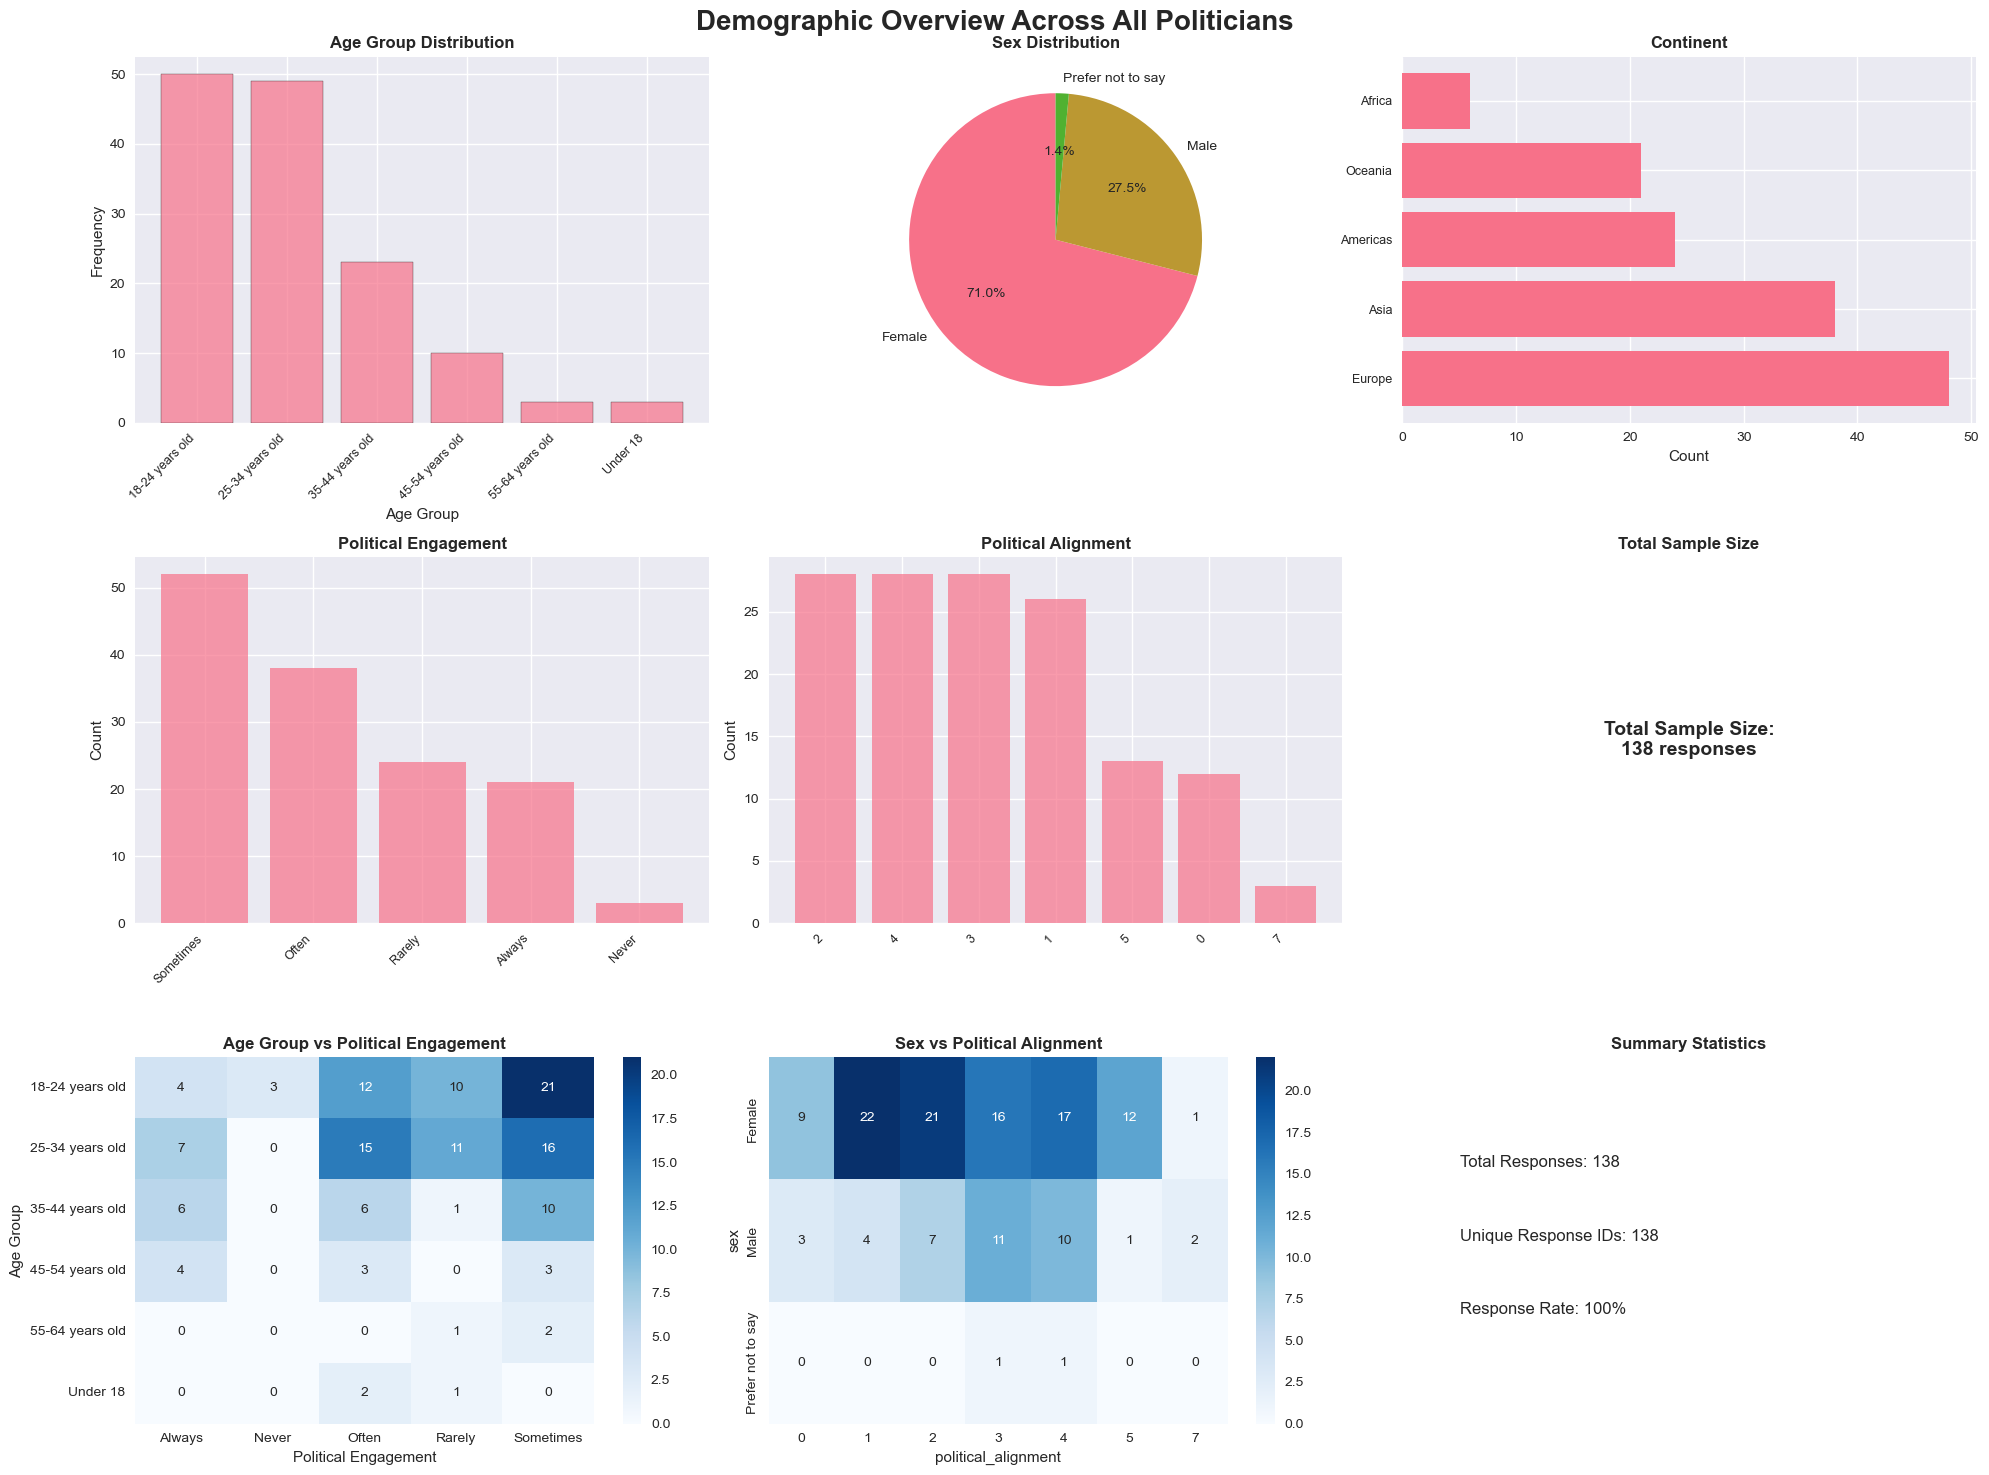

In [168]:
plot_demographic_overview(main_df)

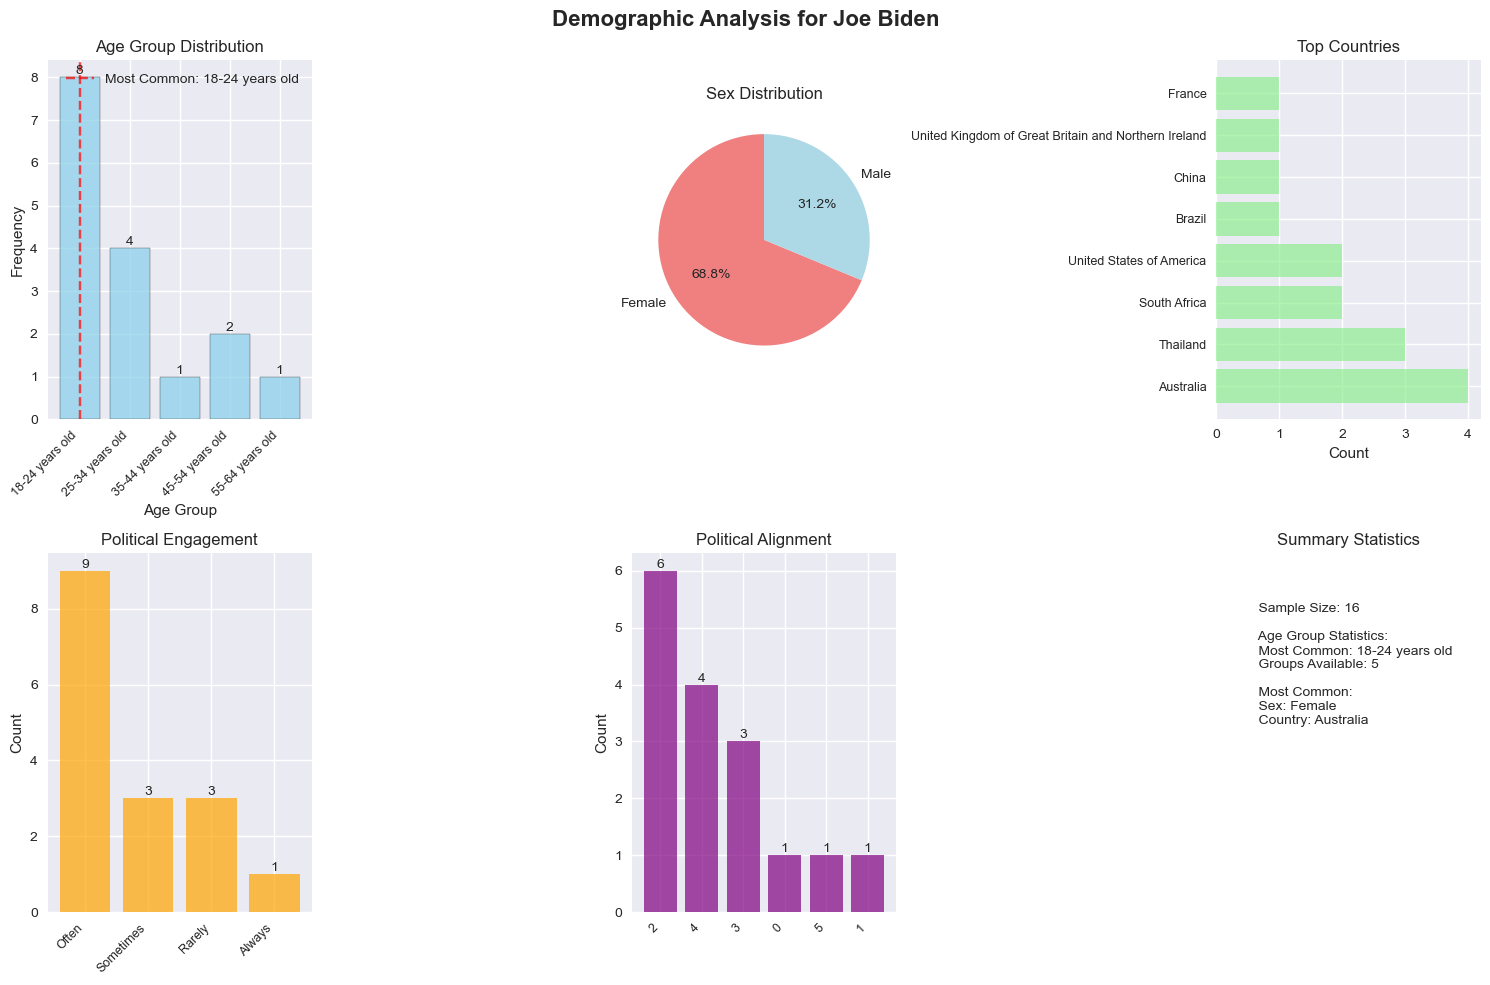

In [169]:
plot_individual_politician_demographics(politician_dfs["Biden"], "Joe Biden")

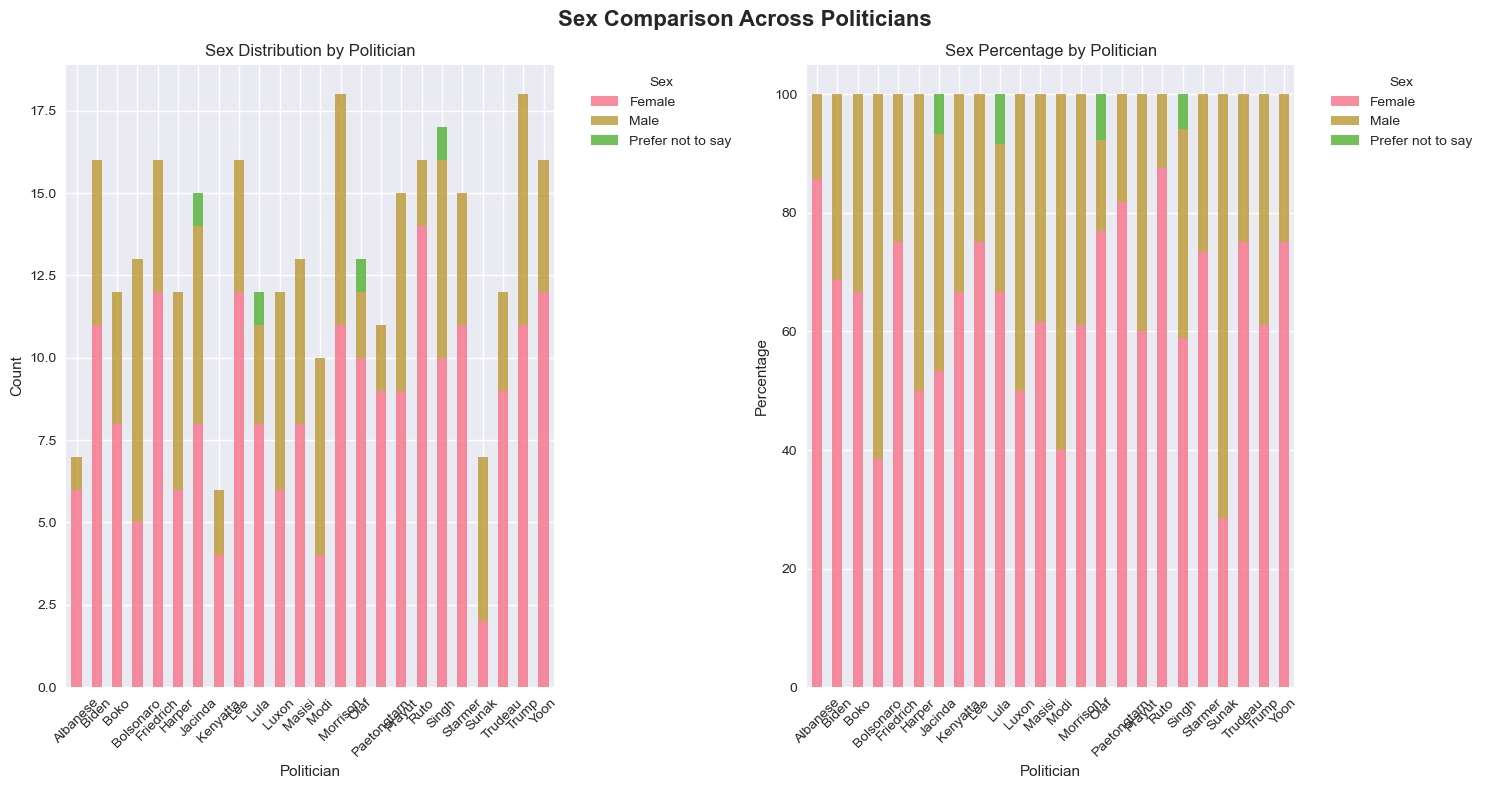

In [170]:
create_demographic_comparison_chart(politician_dfs, 'sex')

In [171]:
generate_demographic_report(main_df)

COMPREHENSIVE DEMOGRAPHIC REPORT

OVERALL STATISTICS:
Total Responses: 138
Unique Response IDs: 138

DEMOGRAPHIC BREAKDOWN:
----------------------------------------
Age Group Statistics:
  Most Common Group: 18-24 years old (50 responses, 36.2%)
  Number of Age Groups: 6
  Age Group Distribution:
    18-24 years old: 50 (36.2%)
    25-34 years old: 49 (35.5%)
    35-44 years old: 23 (16.7%)
    45-54 years old: 10 (7.2%)
    55-64 years old: 3 (2.2%)
    Under 18: 3 (2.2%)

Sex Distribution:
  Female: 98 (71.0%)
  Male: 38 (27.5%)
  Prefer not to say: 2 (1.4%)

Top 10 Countries:
  United Kingdom of Great Britain and Northern Ireland: 28 (20.3%)
  Australia: 21 (15.2%)
  United States of America: 18 (13.0%)
  Thailand: 16 (11.6%)
  India: 4 (2.9%)
  Singapore: 3 (2.2%)
  South Korea: 3 (2.2%)
  South Africa: 3 (2.2%)
  China: 3 (2.2%)
  Poland: 3 (2.2%)

Political Engagement:
  Sometimes: 52 (37.7%)
  Often: 38 (27.5%)
  Rarely: 24 (17.4%)
  Always: 21 (15.2%)
  Never: 3 (2.2%)

Politic

In [177]:
def save_demographic_overview_plots(main_df, figsize=(10, 7), output_dir="plots"):
    """
    Save high-definition demographic overview plots (age, sex, continent, engagement, alignment) to a folder.
    Font sizes are increased for readability.
    """

    os.makedirs(output_dir, exist_ok=True)
    combined_df = main_df[['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment']].copy()

    # Font sizes for improved readability
    title_fs = 20
    label_fs = 12
    tick_fs = 12
    pie_fs = 16

    # 1. Age Group Distribution
    fig, ax = plt.subplots(figsize=figsize)
    age_counts = combined_df['age'].value_counts().sort_index()
    ax.bar(range(len(age_counts)), age_counts.values, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(age_counts)))
    ax.set_xticklabels(age_counts.index, rotation=45, ha='right', fontsize=tick_fs)
    ax.set_title('Age Group Distribution', fontweight='bold', fontsize=title_fs)
    ax.set_xlabel('Age Group', fontsize=label_fs)
    ax.set_ylabel('Frequency', fontsize=label_fs)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/age_group_distribution.png", dpi=300)
    plt.close(fig)

    # 2. Sex Distribution
    fig, ax = plt.subplots(figsize=figsize)
    sex_counts = combined_df['sex'].value_counts()
    wedges, texts, autotexts = ax.pie(
        sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', startangle=90,
        textprops={'fontsize': pie_fs}
    )
    ax.set_title('Sex Distribution', fontweight='bold', fontsize=title_fs)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/sex_distribution.png", dpi=300)
    plt.close(fig)

    # 3. Continent Distribution
    continent_counts = {continet: 0 for continet in countries_by_continent.keys()}
    for country in combined_df['country']:
        for continent, countries in countries_by_continent.items():
            if country in countries:
                continent_counts[continent] += 1
                break
    continent_counts_series = pd.Series(continent_counts)
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(range(len(continent_counts_series)), continent_counts_series.values)
    ax.set_yticks(range(len(continent_counts_series)))
    ax.set_yticklabels(continent_counts_series.index, fontsize=tick_fs)
    ax.set_title('Continent', fontweight='bold', fontsize=title_fs)
    ax.set_xlabel('Count', fontsize=label_fs)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/continent_distribution.png", dpi=300)
    plt.close(fig)

    # 4. Political Engagement Distribution
    fig, ax = plt.subplots(figsize=figsize)
    engagement_counts = combined_df['political_engagement'].value_counts()
    ax.bar(range(len(engagement_counts)), engagement_counts.values, alpha=0.7)
    ax.set_xticks(range(len(engagement_counts)))
    ax.set_xticklabels(engagement_counts.index, rotation=45, ha='right', fontsize=tick_fs)
    ax.set_title('Political Engagement', fontweight='bold', fontsize=title_fs)
    ax.set_ylabel('Count', fontsize=label_fs)
    ax.set_xlabel('Political Engagement', fontsize=label_fs)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/political_engagement_distribution.png", dpi=300)
    plt.close(fig)

    # 5. Political Alignment Distribution
    fig, ax = plt.subplots(figsize=figsize)
    alignment_counts = combined_df['political_alignment'].value_counts()
    ax.bar(range(len(alignment_counts)), alignment_counts.values, alpha=0.7)
    ax.set_xticks(range(len(alignment_counts)))
    ax.set_xticklabels(alignment_counts.index, rotation=45, ha='right', fontsize=tick_fs)
    ax.set_title('Political Alignment', fontweight='bold', fontsize=title_fs)
    ax.set_ylabel('Count', fontsize=label_fs)
    ax.set_xlabel('Political Alignment', fontsize=label_fs)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/political_alignment_distribution.png", dpi=300)
    plt.close(fig)

    print(f"Saved demographic plots (age, sex, continent, engagement, alignment) to '{output_dir}' (size {figsize[0]}x{figsize[1]}, 300 dpi).")

In [178]:
save_demographic_overview_plots(main_df)

Saved demographic plots (age, sex, continent, engagement, alignment) to 'plots' (size 10x7, 300 dpi).


### Phase 2 Extractor

In [ ]:
def get_column_rename_mapping_2(politician_name):
    """
    Get the phase 2 politician-specific column rename mapping
    
    Args:
        politician_name: short name representing the politician 
    
    Returns:
        Dictionary mapping original politician-specific column names to new names
    """
    
    # Politician-specific columns rename mapping
    ranking_rename = {
        f'Rankings_{politician_name}_Q1': 'competence',
        f'Rankings_{politician_name}_Q2': 'likable',
        f'Rankings_{politician_name}_Q3': 'trustworthy',
        f'Rankings_{politician_name}_Q4': 'approachable',
        f'Rankings_{politician_name}_Q5': 'charismatic',
        f'Rankings_{politician_name}_Q6': 'aggressive',
        f'Rankings_{politician_name}_Q7': 'friendly',
        f'Rankings_{politician_name}_Q8': 'professional',
        f'Rankings_{politician_name}_Q9': 'support',
        f'Rankings_{politician_name}_Q10': 'positive',
        f'Rankings_{politician_name}_Q11': 'visually_appealing',
        f'Rankings_{politician_name}_Q12': 'overall_attention',
    }
        
    return ranking_rename    


def filter_politician_columns_2(df, politician_name, demographic_columns=None):
    """
    Filter columns for a specific politician based on the number prefix,
    including demographic columns, renaming columns, and filtering out rows with all empty responses
    
    Args:
        df: pandas DataFrame with the survey data
        politician_name: short name representing the politician 
        demographic_columns: list of demographic column names (already renamed)
    
    Returns:
        DataFrame with demographic columns + politician-specific columns,
        with renamed columns and filtered to only include rows with at least one non-empty politician response
    """
    
    # Define demographic columns - use provided list or default
    if demographic_columns is None:
        demographic_columns = ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment']


    for qid, name in phase2_familiarity.items():
        if politician_name in name:
            familiarity_column = [qid]
    
    # Create pattern to match columns starting with the politician number
    pattern = f"^Rankings_{politician_name}_Q\\d+$"
    
    # Find all columns that match the pattern
    politician_specific_columns = [col for col in df.columns if re.match(pattern, col)]
    
    # Combine demographic columns with politician-specific columns
    # Only include demographic columns that actually exist in the DataFrame
    available_demographic_columns = [col for col in demographic_columns if col in df.columns]
    all_columns = available_demographic_columns + familiarity_column + politician_specific_columns 
    
    if not politician_specific_columns:
        print(f"Warning: No columns found for politician number {politician_name}")
        return pd.DataFrame()

    # Create DataFrame with selected columns
    filtered_df = df[all_columns].copy()
    
    # Filter out rows where ALL politician-specific responses are empty/null
    # A row is kept if at least one politician-specific column has a non-null, non-empty value
    politician_responses = filtered_df[politician_specific_columns]
    
    # Check for non-null and non-empty values (handles both NaN and empty strings)
    has_response = politician_responses.notna() & (politician_responses != '') & (politician_responses != ' ')
    rows_with_responses = has_response.any(axis=1)
    
    # Filter the DataFrame to only include rows with at least one response
    filtered_df = filtered_df[rows_with_responses].copy()
    
    # Rename politician-specific columns using the mapping
    politician_rename_mapping = get_column_rename_mapping_2(politician_name)
    
    # Only rename columns that exist in the DataFrame
    existing_rename_mapping = {old_name: new_name for old_name, new_name in politician_rename_mapping.items() 
                              if old_name in filtered_df.columns}
    
    existing_rename_mapping.update({familiarity_column[0]: 'familiarity'})
    
    filtered_df = filtered_df.rename(columns=existing_rename_mapping)
    
    return filtered_df

def create_all_politician_dataframes_2(df):
    """
    Create individual DataFrames for each politician with common columns included,
    renamed columns, and filtered to only include rows with responses
    
    Args:
        df: pandas DataFrame with the survey data
    
    Returns:
        Dictionary with politician names as keys and their DataFrames as values
    """
    politician_dataframes = {}
    
    for politician_num, politician_name in politicians.items():
        # Filter columns for this politician
        politician_df = filter_politician_columns_2(df, politician_name, demographic_cols)
        
        # Only add to dictionary if DataFrame has data
        if not politician_df.empty and len(politician_df) > 0:
            politician_dataframes[politician_name] = politician_df
            print(f"Created DataFrame for {politician_name}:")
            print(f"  - {len(politician_df.columns)} columns total")
            print(f"  - {len(politician_df)} rows with responses")
            print(f"  - Columns: {list(politician_df.columns)}")
            print()
    
    return politician_dataframes

In [ ]:
politician_dfs_2 = create_all_politician_dataframes_2(main_df)

Created DataFrame for Trump:
  - 19 columns total
  - 15 rows with responses
  - Columns: ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment', 'familiarity', 'competence', 'likable', 'trustworthy', 'approachable', 'charismatic', 'aggressive', 'friendly', 'professional', 'support', 'positive', 'visually_appealing', 'overall_attention']

Created DataFrame for Biden:
  - 19 columns total
  - 17 rows with responses
  - Columns: ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment', 'familiarity', 'competence', 'likable', 'trustworthy', 'approachable', 'charismatic', 'aggressive', 'friendly', 'professional', 'support', 'positive', 'visually_appealing', 'overall_attention']

Created DataFrame for Lee:
  - 19 columns total
  - 15 rows with responses
  - Columns: ['response_id', 'age', 'sex', 'country', 'political_engagement', 'political_alignment', 'familiarity', 'competence', 'likable', 'trustworthy', 'approachable', 'charis

In [ ]:
biden_df_2 = politician_dfs_2["Biden"]
print(biden_df_2.shape)
biden_df_2.head()

(17, 19)


,response_id,age,sex,country,political_engagement,political_alignment,familiarity,competence,likable,trustworthy,approachable,charismatic,aggressive,friendly,professional,support,positive,visually_appealing,overall_attention
1,R_2QQgDHQ3fSXt9QU,25-34 years old,Female,Thailand,Always,2,Extremely familiar,"1,2,3,4","1,3,4,2","1,2,3,4","1,3,4,2","1,3,4,2","4,1,2,3","1,2,4,","1,4,3,2","1,2,4,3","1,2,4,3","1,4,3,2","1,2,3,4"
4,R_2HidVxTG4ScY993,25-34 years old,Male,Finland,Often,2,Very familiar,"1,2,4,3","1,2,4,3","1,3,4,2","1,2,4,3","1,3,4,2","3,2,1,4","3,2,4,1","1,2,4,3","1,3,4,2","1,2,4,3","1,3,4,2","2,3,1,4"
5,R_8I83NkIdLMEbc89,25-34 years old,Male,Indonesia,Sometimes,3,Very familiar,"1,2,3,4","1,2,4,3","1,2,4,3","1,3,4,2","1,2,4,3","2,1,4,3","1,3,4,2","1,2,4,3","1,2,4,3","1,2,4,3","1,2,4,3","1,2,4,3"
6,R_8KE3hTnGWzWMDCI,18-24 years old,Male,Thailand,Rarely,2,Extremely familiar,"1,3,4,2","2,3,4,1","1,3,2,4","3,2,4,1","3,2,4,1","3,1,2,4","3,4,2,1","1,3,2,4","1,2,4,3","2,3,4,1","1,3,4,2","4,1,3,"
8,R_2EnCbWQvoApr8Dz,45-54 years old,Female,United Kingdom of Great Britain and Northern I...,Always,1,Very familiar,"1,2,3,4","1,3,4,2","1,2,3,4","1,2,4,3","1,2,4,3","3,2,1,4","2,1,4,3","1,2,3,4","1,2,4,3","1,2,3,4","1,3,4,2","1,2,3,4"


In [ ]:
save_politician_dataframes(politician_dfs_2, phase="2", output_directory="phase2_data")

Saved Trump data to phase2_data/trump_phase2_data.csv
Saved Biden data to phase2_data/biden_phase2_data.csv
Saved Lee data to phase2_data/lee_phase2_data.csv
Saved Yoon data to phase2_data/yoon_phase2_data.csv
Saved Paetongtarn data to phase2_data/paetongtarn_phase2_data.csv
Saved Prayut data to phase2_data/prayut_phase2_data.csv
Saved Jacinda data to phase2_data/jacinda_phase2_data.csv
Saved Luxon data to phase2_data/luxon_phase2_data.csv
Saved Albanese data to phase2_data/albanese_phase2_data.csv
Saved Morrison data to phase2_data/morrison_phase2_data.csv
Saved Starmer data to phase2_data/starmer_phase2_data.csv
Saved Sunak data to phase2_data/sunak_phase2_data.csv
Saved Friedrich data to phase2_data/friedrich_phase2_data.csv
Saved Olaf data to phase2_data/olaf_phase2_data.csv
Saved Bolsonaro data to phase2_data/bolsonaro_phase2_data.csv
Saved Lula data to phase2_data/lula_phase2_data.csv
Saved Singh data to phase2_data/singh_phase2_data.csv
Saved Modi data to phase2_data/modi_phase2